In [1]:
# Import
# Data & NLP
import re
import pandas as pd
import numpy as np
import inflect

# HuggingFace
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset

# TensorFlow/Keras untuk CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Pembersihan Dataset
p = inflect.engine()

def convert_numbers_to_words(text):
    return " ".join([p.number_to_words(w) if w.isdigit() else w for w in str(text).split()])

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = convert_numbers_to_words(text)
    return text

# Load dataset
train_raw = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-train.csv")
test_raw  = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-test.csv")

# Cleaning
train_clean = train_raw.copy()
test_clean  = test_raw.copy()
train_clean["cleaned_text"] = train_clean["text"].map(clean_text)
test_clean["cleaned_text"]  = test_clean["text"].map(clean_text)

X_train_text = train_clean["cleaned_text"].tolist()
X_test_text  = test_clean["cleaned_text"].tolist()
y_train = train_clean["label"].to_numpy()
y_test  = test_clean["label"].to_numpy()

train_clean[["text","cleaned_text","label"]].head()


,text,cleaned_text,label
0,"He said he had not felt that way before, sugge...",he said he had not felt that way before sugget...,1
1,"Hey there r/assistance, Not sure if this is th...",hey there r assistance not sure if this is the...,0
2,My mom then hit me with the newspaper and it s...,my mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",until i met my new boyfriend he is amazing he ...,1
4,October is Domestic Violence Awareness Month a...,october is domestic violence awareness month a...,1


In [3]:
# Ekstraksi Fitur MentalBERT (untuk CNN)
HF_MODEL_NAME = "mental/mental-bert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
bert_model = AutoModel.from_pretrained(HF_MODEL_NAME)

def get_embeddings(texts):
    embs = []
    for t in texts:
        enc = tokenizer(t, max_length=MAX_LEN, truncation=True, padding="max_length", return_tensors="pt")
        with torch.no_grad():
            out = bert_model(**enc)
        cls = out.last_hidden_state[:,0,:].numpy()
        embs.append(cls)
    stacked = np.vstack(embs)               # (N,768)
    return np.expand_dims(stacked, axis=1)  # (N,1,768)

X_train_bert = get_embeddings(X_train_text)
X_test_bert  = get_embeddings(X_test_text)

print("Embeddings MentalBERT:", X_train_bert.shape, X_test_bert.shape)


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embeddings MentalBERT: (2838, 1, 768) (715, 1, 768)


In [4]:
# CNN Model
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(128, 1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn_model = build_cnn((1,768))
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            98432     
                                                                 
 batch_normalization (Batch  (None, 1, 128)            512       
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                

In [5]:
# Training CNN (Feature Extractor MentalBERT)
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

hist_cnn = cnn_model.fit(
    X_train_bert, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    callbacks=[es, rl],
    verbose=1
)

y_pred_cnn = (cnn_model.predict(X_test_bert) >= 0.5).astype(int).ravel()
print("== CNN + MentalBERT (Feature Extractor) ==")
print(classification_report(y_test, y_pred_cnn, target_names=["NotDep","Dep"]))


Epoch 1/20


284/284 [==============================] - 3s 5ms/step - loss: 1.3381 - accuracy: 0.6793 - val_loss: 0.8436 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 2/20
284/284 [==============================] - 1s 4ms/step - loss: 0.9895 - accuracy: 0.7176 - val_loss: 0.7049 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 3/20
284/284 [==============================] - 1s 4ms/step - loss: 0.8391 - accuracy: 0.7304 - val_loss: 0.6357 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 4/20
284/284 [==============================] - 1s 4ms/step - loss: 0.7386 - accuracy: 0.7458 - val_loss: 0.5701 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 5/20
284/284 [==============================] - 1s 4ms/step - loss: 0.6820 - accuracy: 0.7595 - val_loss: 0.5314 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 6/20
284/284 [==============================] - 1s 4ms/step - loss: 0.6209 - accuracy: 0.7784 - val_loss: 0.4934 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 7/20
284/284 [==============================] - 1s 4ms/step - 

In [6]:
import accelerate
import torch, transformers
print("Accelerate:", accelerate.__version__)
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)


Accelerate: 1.10.1
Torch: 2.5.1+cu121
Transformers: 4.40.1


In [7]:
import accelerate 
print("Accelerate version:", accelerate.__version__)

# Fine-tuned MentalBERT (End-to-End)
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(X_train_text, y_train, tokenizer, MAX_LEN)
test_dataset  = TextDataset(X_test_text, y_test, tokenizer, MAX_LEN)

ft_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50
)

trainer = Trainer(
    model=ft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

trainer.train()


Accelerate version: 1.10.1


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▍         | 50/1065 [00:24<07:58,  2.12it/s]

{'loss': 0.5999, 'grad_norm': 4.787375450134277, 'learning_rate': 4.765258215962441e-05, 'epoch': 0.14}


  9%|▉         | 100/1065 [00:47<07:32,  2.13it/s]

{'loss': 0.5033, 'grad_norm': 5.1289215087890625, 'learning_rate': 4.530516431924883e-05, 'epoch': 0.28}


 14%|█▍        | 150/1065 [01:11<07:07,  2.14it/s]

{'loss': 0.4678, 'grad_norm': 9.528435707092285, 'learning_rate': 4.295774647887324e-05, 'epoch': 0.42}


 19%|█▉        | 200/1065 [01:34<06:47,  2.12it/s]

{'loss': 0.471, 'grad_norm': 8.06511402130127, 'learning_rate': 4.0610328638497654e-05, 'epoch': 0.56}


 23%|██▎       | 250/1065 [01:58<06:22,  2.13it/s]

{'loss': 0.4797, 'grad_norm': 9.760616302490234, 'learning_rate': 3.826291079812207e-05, 'epoch': 0.7}


 28%|██▊       | 300/1065 [02:21<06:02,  2.11it/s]

{'loss': 0.4459, 'grad_norm': 6.587440490722656, 'learning_rate': 3.5915492957746486e-05, 'epoch': 0.85}


 33%|███▎      | 350/1065 [02:44<05:28,  2.18it/s]

{'loss': 0.3852, 'grad_norm': 5.787770748138428, 'learning_rate': 3.3568075117370895e-05, 'epoch': 0.99}


                                                  
 33%|███▎      | 355/1065 [03:01<05:05,  2.33it/s]

{'eval_loss': 0.5229569673538208, 'eval_runtime': 14.3909, 'eval_samples_per_second': 49.684, 'eval_steps_per_second': 6.254, 'epoch': 1.0}


 38%|███▊      | 400/1065 [03:48<05:04,  2.18it/s]  

{'loss': 0.2376, 'grad_norm': 2.1692774295806885, 'learning_rate': 3.1220657276995305e-05, 'epoch': 1.13}


 42%|████▏     | 450/1065 [04:11<04:42,  2.18it/s]

{'loss': 0.3267, 'grad_norm': 0.8776504397392273, 'learning_rate': 2.887323943661972e-05, 'epoch': 1.27}


 47%|████▋     | 500/1065 [04:34<04:19,  2.18it/s]

{'loss': 0.1868, 'grad_norm': 0.28674444556236267, 'learning_rate': 2.6525821596244134e-05, 'epoch': 1.41}


 52%|█████▏    | 550/1065 [04:57<03:56,  2.18it/s]

{'loss': 0.2567, 'grad_norm': 1.7102887630462646, 'learning_rate': 2.4178403755868547e-05, 'epoch': 1.55}


 56%|█████▋    | 600/1065 [05:20<03:31,  2.19it/s]

{'loss': 0.2267, 'grad_norm': 0.06928735971450806, 'learning_rate': 2.1830985915492956e-05, 'epoch': 1.69}


 61%|██████    | 650/1065 [05:43<03:10,  2.18it/s]

{'loss': 0.236, 'grad_norm': 51.047767639160156, 'learning_rate': 1.9483568075117372e-05, 'epoch': 1.83}


 66%|██████▌   | 700/1065 [06:06<02:50,  2.14it/s]

{'loss': 0.2339, 'grad_norm': 0.12672200798988342, 'learning_rate': 1.7136150234741785e-05, 'epoch': 1.97}


                                                  
 67%|██████▋   | 710/1065 [06:25<02:35,  2.29it/s]

{'eval_loss': 0.7310921549797058, 'eval_runtime': 14.7593, 'eval_samples_per_second': 48.444, 'eval_steps_per_second': 6.098, 'epoch': 2.0}


 70%|███████   | 750/1065 [06:51<02:28,  2.12it/s]

{'loss': 0.091, 'grad_norm': 0.07121682912111282, 'learning_rate': 1.4788732394366198e-05, 'epoch': 2.11}


 75%|███████▌  | 800/1065 [07:14<02:01,  2.18it/s]

{'loss': 0.0787, 'grad_norm': 0.0774666965007782, 'learning_rate': 1.2441314553990612e-05, 'epoch': 2.25}


 80%|███████▉  | 850/1065 [07:37<01:38,  2.18it/s]

{'loss': 0.0889, 'grad_norm': 0.03462604060769081, 'learning_rate': 1.0093896713615023e-05, 'epoch': 2.39}


 85%|████████▍ | 900/1065 [08:00<01:17,  2.14it/s]

{'loss': 0.0827, 'grad_norm': 0.03923279419541359, 'learning_rate': 7.746478873239436e-06, 'epoch': 2.54}


 89%|████████▉ | 950/1065 [08:23<00:52,  2.18it/s]

{'loss': 0.0708, 'grad_norm': 0.03307748958468437, 'learning_rate': 5.3990610328638506e-06, 'epoch': 2.68}


 94%|█████████▍| 1000/1065 [08:46<00:29,  2.19it/s]

{'loss': 0.0822, 'grad_norm': 0.08028566092252731, 'learning_rate': 3.051643192488263e-06, 'epoch': 2.82}


 99%|█████████▊| 1050/1065 [09:09<00:06,  2.18it/s]

{'loss': 0.1125, 'grad_norm': 0.05904803052544594, 'learning_rate': 7.042253521126761e-07, 'epoch': 2.96}


                                                   
100%|██████████| 1065/1065 [09:30<00:00,  2.33it/s]

{'eval_loss': 1.048870325088501, 'eval_runtime': 14.3935, 'eval_samples_per_second': 49.675, 'eval_steps_per_second': 6.253, 'epoch': 3.0}


100%|██████████| 1065/1065 [09:38<00:00,  1.84it/s]

{'train_runtime': 578.2335, 'train_samples_per_second': 14.724, 'train_steps_per_second': 1.842, 'train_loss': 0.26600259299709206, 'epoch': 3.0}


TrainOutput(global_step=1065, training_loss=0.26600259299709206, metrics={'train_runtime': 578.2335, 'train_samples_per_second': 14.724, 'train_steps_per_second': 1.842, 'total_flos': 560031881333760.0, 'train_loss': 0.26600259299709206, 'epoch': 3.0})

== Evaluasi CNN + MentalBERT ==
              precision    recall  f1-score   support

      NotDep       0.82      0.76      0.79       346
         Dep       0.79      0.85      0.82       369

    accuracy                           0.80       715
   macro avg       0.81      0.80      0.80       715
weighted avg       0.81      0.80      0.80       715



100%|██████████| 90/90 [00:14<00:00,  6.22it/s]


== Evaluasi Fine-tuned MentalBERT ==
              precision    recall  f1-score   support

      NotDep       0.84      0.73      0.78       346
         Dep       0.78      0.87      0.82       369

    accuracy                           0.80       715
   macro avg       0.81      0.80      0.80       715
weighted avg       0.81      0.80      0.80       715



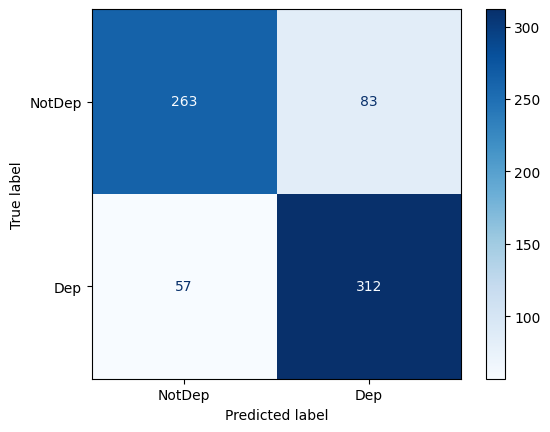

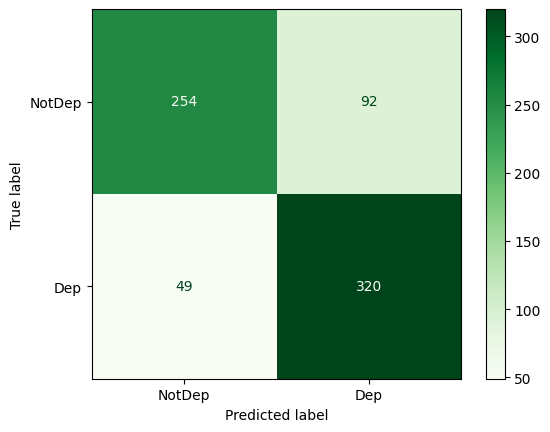

In [8]:
# Evaluasi Kedua Model
# Evaluasi CNN
print("== Evaluasi CNN + MentalBERT ==")
print(classification_report(y_test, y_pred_cnn, target_names=["NotDep","Dep"]))
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
ConfusionMatrixDisplay(cm_cnn, display_labels=["NotDep","Dep"]).plot(cmap="Blues")

# Evaluasi Fine-tuned MentalBERT
preds_ft = trainer.predict(test_dataset)
y_pred_ft = np.argmax(preds_ft.predictions, axis=1)

print("\n== Evaluasi Fine-tuned MentalBERT ==")
print(classification_report(y_test, y_pred_ft, target_names=["NotDep","Dep"]))
cm_ft = confusion_matrix(y_test, y_pred_ft)
ConfusionMatrixDisplay(cm_ft, display_labels=["NotDep","Dep"]).plot(cmap="Greens")


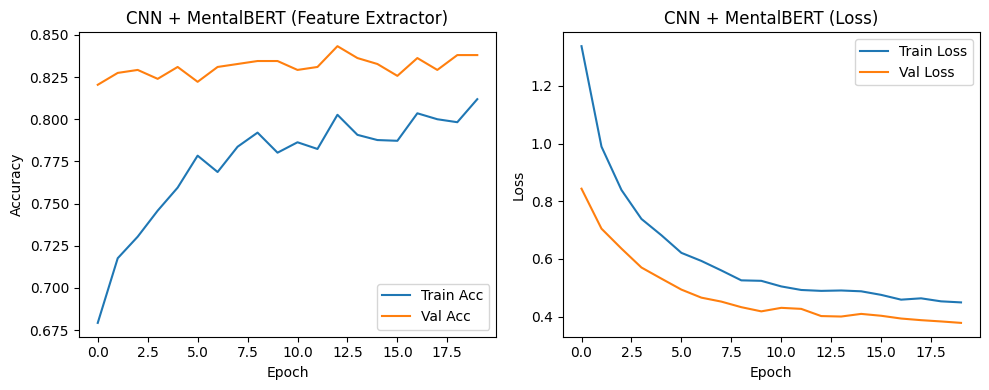

,Model,Akurasi
0,CNN + MentalBERT (Extractor),0.804196
1,Fine-tuned MentalBERT,0.802797


In [9]:
# Visualisasi & Perbandingan
# Kurva training CNN
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_cnn.history.get("accuracy",[]), label="Train Acc")
plt.plot(hist_cnn.history.get("val_accuracy",[]), label="Val Acc")
plt.title("CNN + MentalBERT (Feature Extractor)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_cnn.history.get("loss",[]), label="Train Loss")
plt.plot(hist_cnn.history.get("val_loss",[]), label="Val Loss")
plt.title("CNN + MentalBERT (Loss)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

# Tabel ringkas perbandingan
df_compare = pd.DataFrame({
    "Model": ["CNN + MentalBERT (Extractor)", "Fine-tuned MentalBERT"],
    "Akurasi": [
        (y_test == y_pred_cnn).mean(),
        (y_test == y_pred_ft).mean()
    ]
})
df_compare
